In [2]:
import os
import sys
import vcf
import glob
import pandas as pd

## Custom parsers

### Fasta parser

In [3]:
import os
import re
import sys
import time
import glob
import numpy
import argparse
from operator import attrgetter
from collections import namedtuple
from collections import OrderedDict

class Fasta:

	def __init__(self, fasta_path):
		self.fasta_path = fasta_path
		return

	def peek(self, fasta_handle):
		curr_pos = fasta_handle.tell()
		curr_line = fasta_handle.readline()
		fasta_handle.seek(curr_pos)
		return(curr_line)

	def read(self):
		'''Given a fasta file, read will iterate through the file and yield each record, alonf with the header information, custom fasta id, length of sequence.'''
		fasta_handle = open(self.fasta_path)

		#Read the file one line at a time and process a chunk of text until the next header is found. At this point, process the chunk of text as one sequence and create iterator.
		next_line = ''
		line_number = 0
		header = ''
		sequence = ''
		header_found = False
		fid = 0
		while True:
			fasta = namedtuple('fastaRec', ['header', 'seq', 'fid', 'length'])
			next_line = self.peek(fasta_handle)
			try:
					if next_line[0] == '>':
						header = fasta_handle.readline().strip()[1:]
					sequence = ''
					fid += 1
					header_found = True
					line_number += 1
					while True:
						try:
								if self.peek(fasta_handle)[0] != '>' and self.peek(fasta_handle) != ' \n': 
									sequence += fasta_handle.readline().strip()
									header_found = False
									line_number += 1

								elif (self.peek(fasta_handle) == ' \n' or self.peek(fasta_handle)[0] == '>') and header_found:
									line_number += 1
									raise SyntaxError('Sequence missing for header : {0} at line {1}'.format(header, line_number))
									sys.exit()
								elif self.peek(fasta_handle)[0] == '>' and not header_found:
									break					
						except IndexError:
								break								
					length = len(sequence)
					record = fasta(header, sequence, fid, length)
					yield record
			except IndexError:
				break					

	def write(self, out_path, reader_obj, wrapping = 0):
		'''Given a fasta object and a output path, will write out a fasta file.'''

		fasta_handle = open(out_path, 'w')
		seq = ''
		for sequences in reader_obj:
			if wrapping == 0:
				wrapping = len(sequences.seq)
			seq = re.findall('.{{1,{0}}}'.format(wrapping), sequences.seq)
			fasta_handle.write('>{0}|{1}|{2}\n'.format(sequences.header, sequences.length, len(''.join(seq))))
			for record in seq:
				fasta_handle.write('{0}\n'.format(record))
		fasta_handle.close()
		return					


### Codon table

In [4]:
def getAA(codon):
    codontable = {
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'
        }
    return(codontable[codon])

def getCodon(aa):
    aatable= {
        'I' : 'ATA,ATC,ATT',
        'M' : 'ATG',
        'T' : 'ACA,ACC,ACG,ACT',
        'N' : 'AAC,AAT',
        'K' : 'AAA,AAG',
        'S' : 'AGC,AGT',
        'R' : 'AGA,AGG',
        'L' : 'CTA,CTC,CTG,CTT',
        'P' : 'CCA,CCC,CCG,CCT',
        'H' : 'CAC,CAT',
        'Q' : 'CAA,CAG',
        'R' : 'CGA,CGC,CGG,CGT',
        'V' : 'GTA,GTC,GTG,GTT',
        'A' : 'GCA,GCC,GCG,GCT',
        'D' : 'GAC,GAT',
        'E' : 'GAA,GAG',
        'G' : 'GGA,GGC,GGG,GGT',
        'S' : 'TCA,TCC,TCG,TCT',
        'F' : 'TTC,TTT',
        'L' : 'TTA,TTG',
        'Y' : 'TAC,TAT',
        'C' : 'TGC,TGT',
        '_' : 'TAA,TAG,TGA',
        'W' : 'TGG'
        
    }
    return(aatable[aa])

## Format variants of interest data

In [5]:
voi = pd.read_excel('./Reportable_SNPs_Report_v2.xlsx', sheetname=1, parse_cols="B:C")
voi.head()

,Gene,SNP
0,PfCRT,M74I
1,PfCRT,N75E
2,PfCRT,K76T
3,PfCRT,A220S
4,PfCRT,Q271E


In [6]:
voi['Ref'] = voi['SNP'].str.split('\d+', expand=True)[0]
voi['Alt'] = voi['SNP'].str.split('\d+', expand=True)[1]
voi['Pos'] = voi['SNP'].str.split('[a-zA-Z]',expand=True)[1]
voi = voi[['Gene','Pos','Ref','Alt']]
voi[['Pos']] = voi[['Pos']].apply(pd.to_numeric)
voi.set_index(['Gene','Pos'], inplace=True)
voi.head()

Ref Alt
Gene  Pos        
PfCRT 74    M   I
      75    N   E
      76    K   T
      220   A   S
      271   Q   E

## Create codon table for genes

In [7]:
# Read fasta file
reader = Fasta('../../ref/mdr.fa')

#Read bed file
bed = pd.read_table('../../ref/mdr.bed', header=None, sep='\t', names=['Gene','Start','Stop','Exon','Info','Strand'])
bed

,Gene,Start,Stop,Exon,Info,Strand
0,PfCRT,96,186,exon1,.,+
1,PfCRT,364,632,exon2,.,+
2,PfCRT,812,984,exon3,.,+
3,PfCRT,1157,1289,exon4,.,+
4,PfCRT,1443,1514,exon5,.,+
5,PfCRT,1638,1713,exon6,.,+
6,PfCRT,1810,1892,exon7,.,+
7,PfCRT,2020,2070,exon8,.,+
8,PfCRT,2208,2264,exon9,.,+
9,PfCRT,2413,2505,exon10,.,+


In [8]:
#Spliting in codons
bed_iter = iter(bed.iterrows())
fasta = reader.read()


In [9]:
codon_dict = dict()
codon = list()
codon_table = list()
for records in fasta:
    seq = iter(records.seq)
    cdna = []
    for pos, base in enumerate(seq, 1):
        for exons in bed.iterrows():
            if exons[1]['Gene'] == records.header:
                if pos in range(exons[1]['Start'], exons[1]['Stop']+1):
                    cdna.append((base, pos, exons[1]['Strand']))
                else:
                    continue
            else:
                continue
    aa = []
    codon = 0
    sequence = cdna #iter(cdna)
    codon_pos = 0
    for bases in range(0, len(cdna),3):
        codon += 1
        codon_list = cdna[bases:bases+3] if cdna[bases][2] == '+' else cdna[bases:bases+3][::-1]
        codon_seq = ''.join([val[0] for val in codon_list])
        for codon_pos, nuc in enumerate(codon_list):
            codon_table.append((records.header, (records.header, nuc[1], nuc[0], codon, codon_seq, getAA(codon_seq), codon_pos)))
        
codon_data = pd.DataFrame.from_items(codon_table, orient='index', columns=['Gene', 'NucPos', 'Nuc', 'Pos', 'Codon', 'AA', 'CodoPos'])                        
codon_data[['Pos']] = codon_data[['Pos']].apply(pd.to_numeric)
codon_data.set_index(['Gene', 'Pos'], inplace=True)
codon_data.head()
    #while True:
    #    try:
    #        codon += 1
    #        codon_seq = next(sequence[0])+next(sequence[0])+next(sequence[0])
    #        aa_seq = getAA(codon_seq)
    #        aa.append((codon_seq, codon, getAA(codon_seq)))
    #    except StopIteration:
    #       break
    #codon_dict[records.header] = aa




NucPos Nuc Codon AA  CodoPos
Gene  Pos                              
PfCRT 1        96   A   ATG  M        0
      1        97   T   ATG  M        1
      1        98   G   ATG  M        2
      2        99   A   AAA  K        0
      2       100   A   AAA  K        1

In [10]:
codons_of_int = voi.merge(codon_data, left_index=True, right_index=True, how='inner' )

In [11]:
codons_of_int

Ref Alt  NucPos Nuc Codon AA  CodoPos
Gene   Pos                                       
DHFR   51     N   I     151   A   AAT  N        0
       51     N   I     152   A   AAT  N        1
       51     N   I     153   T   AAT  N        2
       59     C   R     175   T   TGT  C        0
       59     C   R     176   G   TGT  C        1
       59     C   R     177   T   TGT  C        2
       108    S   N     322   A   AGC  S        0
       108    S   N     323   G   AGC  S        1
       108    S   N     324   C   AGC  S        2
DHPS   436    S   A    1482   T   TCT  S        0
       436    S   A    1483   C   TCT  S        1
       436    S   A    1484   T   TCT  S        2
       436    S   F    1482   T   TCT  S        0
       436    S   F    1483   C   TCT  S        1
       436    S   F    1484   T   TCT  S        2
       437    G   A    1485   G   GGT  G        0
       437    G   A    1486   G   GGT  G        1
       437    G   A    1487   T   GGT  G        2
       540    G   E    1794   A   AAA  K        0
       540    G   E    1795   A   AAA  K        1
       540    G   E    1796   A   AAA  K        2
       581    A   G    1917   G   GCG  A        0
       581    A   G    1918   C   GCG  A        1
       581    A   G    1919   G   GCG  A        2
       613    A   S    2013   G   GCC  A        0
       613    A   S    2014   C   GCC  A        1
       613    A   S    2015   C   GCC  A        2
       613    A   T    2013   G   GCC  A        0
       613    A   T    2014   C   GCC  A        1
       613    A   T    2015   C   GCC  A        2
...          ..  ..     ...  ..   ... ..      ...
PfCRT  271    Q   E    1710   C   CAA  Q        0
       271    Q   E    1711   A   CAA  Q        1
       271    Q   E    1712   A   CAA  Q        2
       326    N   S    2235   A   AAC  N        0
       326    N   S    2236   A   AAC  N        1
       326    N   S    2237   C   AAC  N        2
       350    C   S    2455   T   TGT  C        0
       350    C   S    2456   G   TGT  C        1
       350    C   S    2457   T   TGT  C        2
       356    I   T    2473   A   ATA  I        0
       356    I   T    2474   T   ATA  I        1
       356    I   T    2475   A   ATA  I        2
       371    R   I    2711   A   AGA  R        0
       371    R   I    2712   G   AGA  R        1
       371    R   I    2713   A   AGA  R        2
PfMDR1 86     N   Y     256   A   AAT  N        0
       86     N   Y     257   A   AAT  N        1
       86     N   Y     258   T   AAT  N        2
       184    Y   F     550   T   TAT  Y        0
       184    Y   F     551   A   TAT  Y        1
       184    Y   F     552   T   TAT  Y        2
       1034   S   C    3100   A   AGT  S        0
       1034   S   C    3101   G   AGT  S        1
       1034   S   C    3102   T   AGT  S        2
       1042   N   D    3124   A   AAT  N        0
       1042   N   D    3125   A   AAT  N        1
       1042   N   D    3126   T   AAT  N        2
       1246   D   Y    3736   G   GAT  D        0
       1246   D   Y    3737   A   GAT  D        1
       1246   D   Y    3738   T   GAT  D        2

[147 rows x 7 columns]

In [12]:
codons_of_int['AltCodon'] = codons_of_int['Alt'].apply(getCodon)

In [13]:
codons_of_int.head()

Ref Alt  NucPos Nuc Codon AA  CodoPos         AltCodon
Gene Pos                                                       
DHFR 51    N   I     151   A   AAT  N        0      ATA,ATC,ATT
     51    N   I     152   A   AAT  N        1      ATA,ATC,ATT
     51    N   I     153   T   AAT  N        2      ATA,ATC,ATT
     59    C   R     175   T   TGT  C        0  CGA,CGC,CGG,CGT
     59    C   R     176   G   TGT  C        1  CGA,CGC,CGG,CGT

In [14]:
codons_of_int.to_excel('Codon_table.xlsx')


In [15]:
sample = vcf.Reader(filename='../../local/Sample_5685_F_KEL5430A24/Sample_5685_F_KEL5430A24_variants_merged_annotated.vcf')
codon_table = pd.read_excel('Codon_table.xlsx')

sample_name = sample.samples[0]

In [16]:
codons_of_int.head()

Ref Alt  NucPos Nuc Codon AA  CodoPos         AltCodon
Gene Pos                                                       
DHFR 51    N   I     151   A   AAT  N        0      ATA,ATC,ATT
     51    N   I     152   A   AAT  N        1      ATA,ATC,ATT
     51    N   I     153   T   AAT  N        2      ATA,ATC,ATT
     59    C   R     175   T   TGT  C        0  CGA,CGC,CGG,CGT
     59    C   R     176   G   TGT  C        1  CGA,CGC,CGG,CGT

In [17]:
import math
sample_files = glob.glob('../../local/*/*_merged_annotated.vcf')
for files in sample_files:
    sample = vcf.Reader(filename=files)
    sample_name = sample.samples[0]
    sample_result = []
    sample_vars = {'{0}_{1}_{2}_{3}'.format(var.CHROM, var.POS, var.INFO['RefAA'][0], var.INFO['AltAA'][0]): var.INFO['DP'] for var in sample}
    for val in codons_of_int.iterrows():
        if '{0}_{1}_{2}_{3}'.format(val[0][0], val[1]['NucPos'], val[1]['Ref'],val[1]['Alt']) in sample_vars.keys():
            depth = math.log(sample_vars['{0}_{1}_{2}_{3}'.format(val[0][0], val[1]['NucPos'], val[1]['Ref'],val[1]['Alt'])])
            sample_result.append(depth)
        else:
            sample_result.append(0)
    sample_series = pd.Series(sample_result, index=codons_of_int.index)
    codons_of_int[sample_name] = sample_series


In [18]:
codons_of_int

Ref Alt  NucPos Nuc Codon AA  CodoPos         AltCodon  \
Gene   Pos                                                           
DHFR   51     N   I     151   A   AAT  N        0      ATA,ATC,ATT   
       51     N   I     152   A   AAT  N        1      ATA,ATC,ATT   
       51     N   I     153   T   AAT  N        2      ATA,ATC,ATT   
       59     C   R     175   T   TGT  C        0  CGA,CGC,CGG,CGT   
       59     C   R     176   G   TGT  C        1  CGA,CGC,CGG,CGT   
       59     C   R     177   T   TGT  C        2  CGA,CGC,CGG,CGT   
       108    S   N     322   A   AGC  S        0          AAC,AAT   
       108    S   N     323   G   AGC  S        1          AAC,AAT   
       108    S   N     324   C   AGC  S        2          AAC,AAT   
DHPS   436    S   A    1482   T   TCT  S        0  GCA,GCC,GCG,GCT   
       436    S   A    1483   C   TCT  S        1  GCA,GCC,GCG,GCT   
       436    S   A    1484   T   TCT  S        2  GCA,GCC,GCG,GCT   
       436    S   F    1482   T   TCT  S        0          TTC,TTT   
       436    S   F    1483   C   TCT  S        1          TTC,TTT   
       436    S   F    1484   T   TCT  S        2          TTC,TTT   
       437    G   A    1485   G   GGT  G        0  GCA,GCC,GCG,GCT   
       437    G   A    1486   G   GGT  G        1  GCA,GCC,GCG,GCT   
       437    G   A    1487   T   GGT  G        2  GCA,GCC,GCG,GCT   
       540    G   E    1794   A   AAA  K        0          GAA,GAG   
       540    G   E    1795   A   AAA  K        1          GAA,GAG   
       540    G   E    1796   A   AAA  K        2          GAA,GAG   
       581    A   G    1917   G   GCG  A        0  GGA,GGC,GGG,GGT   
       581    A   G    1918   C   GCG  A        1  GGA,GGC,GGG,GGT   
       581    A   G    1919   G   GCG  A        2  GGA,GGC,GGG,GGT   
       613    A   S    2013   G   GCC  A        0  TCA,TCC,TCG,TCT   
       613    A   S    2014   C   GCC  A        1  TCA,TCC,TCG,TCT   
       613    A   S    2015   C   GCC  A        2  TCA,TCC,TCG,TCT   
       613    A   T    2013   G   GCC  A        0  ACA,ACC,ACG,ACT   
       613    A   T    2014   C   GCC  A        1  ACA,ACC,ACG,ACT   
       613    A   T    2015   C   GCC  A        2  ACA,ACC,ACG,ACT   
...          ..  ..     ...  ..   ... ..      ...              ...   
PfCRT  271    Q   E    1710   C   CAA  Q        0          GAA,GAG   
       271    Q   E    1711   A   CAA  Q        1          GAA,GAG   
       271    Q   E    1712   A   CAA  Q        2          GAA,GAG   
       326    N   S    2235   A   AAC  N        0  TCA,TCC,TCG,TCT   
       326    N   S    2236   A   AAC  N        1  TCA,TCC,TCG,TCT   
       326    N   S    2237   C   AAC  N        2  TCA,TCC,TCG,TCT   
       350    C   S    2455   T   TGT  C        0  TCA,TCC,TCG,TCT   
       350    C   S    2456   G   TGT  C        1  TCA,TCC,TCG,TCT   
       350    C   S    2457   T   TGT  C        2  TCA,TCC,TCG,TCT   
       356    I   T    2473   A   ATA  I        0  ACA,ACC,ACG,ACT   
       356    I   T    2474   T   ATA  I        1  ACA,ACC,ACG,ACT   
       356    I   T    2475   A   ATA  I        2  ACA,ACC,ACG,ACT   
       371    R   I    2711   A   AGA  R        0      ATA,ATC,ATT   
       371    R   I    2712   G   AGA  R        1      ATA,ATC,ATT   
       371    R   I    2713   A   AGA  R        2      ATA,ATC,ATT   
PfMDR1 86     N   Y     256   A   AAT  N        0          TAC,TAT   
       86     N   Y     257   A   AAT  N        1          TAC,TAT   
       86     N   Y     258   T   AAT  N        2          TAC,TAT   
       184    Y   F     550   T   TAT  Y        0          TTC,TTT   
       184    Y   F     551   A   TAT  Y        1          TTC,TTT   
       184    Y   F     552   T   TAT  Y        2          TTC,TTT   
       1034   S   C    3100   A   AGT  S        0          TGC,TGT   
       1034   S   C    3101   G   AGT  S        1          TGC,TGT   
       1034   S   C    3102   T   AGT  S        2          TGC,TGT   
       1042   N   D   

In [19]:
len(codons_of_int.columns)

89

In [20]:
codons_of_int.iloc[:,9:]

Sample_5689_F_KEL5430A23  Sample_5690_F_KEL5430A26  \
Gene   Pos                                                        
DHFR   51                    0.000000                  0.000000   
       51                    5.030438                  5.771441   
       51                    0.000000                  0.000000   
       59                    5.093750                  5.843544   
       59                    0.000000                  0.000000   
       59                    0.000000                  0.000000   
       108                   0.000000                  0.000000   
       108                   5.198497                  5.908083   
       108                   0.000000                  0.000000   
DHPS   436                   0.000000                  5.860786   
       436                   0.000000                  0.000000   
       436                   0.000000                  0.000000   
       436                   0.000000                  0.000000   
       436                   0.000000                  0.000000   
       436                   0.000000                  0.000000   
       437                   0.000000                  0.000000   
       437                   0.000000                  0.000000   
       437                   0.000000                  0.000000   
       540                   0.000000                  0.000000   
       540                   0.000000                  0.000000   
       540                   0.000000                  0.000000   
       581                   0.000000                  0.000000   
       581                   0.000000                  5.831882   
       581                   0.000000                  0.000000   
       613                   0.000000                  5.860786   
       613                   0.000000                  0.000000   
       613                   0.000000                  0.000000   
       613                   0.000000                  0.000000   
       613                   0.000000                  0.000000   
       613                   0.000000                  0.000000   
...                               ...                       ...   
PfCRT  271                   3.555348                  3.258097   
       271                   0.000000                  0.000000   
       271                   0.000000                  0.000000   
       326                   0.000000                  0.000000   
       326                   0.000000                  0.000000   
       326                   0.000000                  0.000000   
       350                   0.000000                  0.000000   
       350                   0.000000                  0.000000   
       350                   0.000000                  0.000000   
       356                   0.000000                  0.000000   
       356                   3.295837                  0.000000   
       356                   0.000000                  0.000000   
       371                   0.000000                  0.000000   
       371                   2.708050                  2.890372   
       371                   0.000000                  0.000000   
PfMDR1 86                    3.332205                  0.000000   
       86                    0.000000                  0.000000   
       86                    0.000000                  0.000000   
       184                   0.000000                  0.000000   
       184                   4.290459                  0.000000   
       184                   0.000000                  0.000000   
       1034                  0.000000                  0.000000   
       1034                  0.000000                  0.000000   
       1034                  0.000000                  0.000000   
       1042                  0.000000                  0.000000   
       1042                  0.000000                  0.000000   
       1042                  0.000000                  0.000

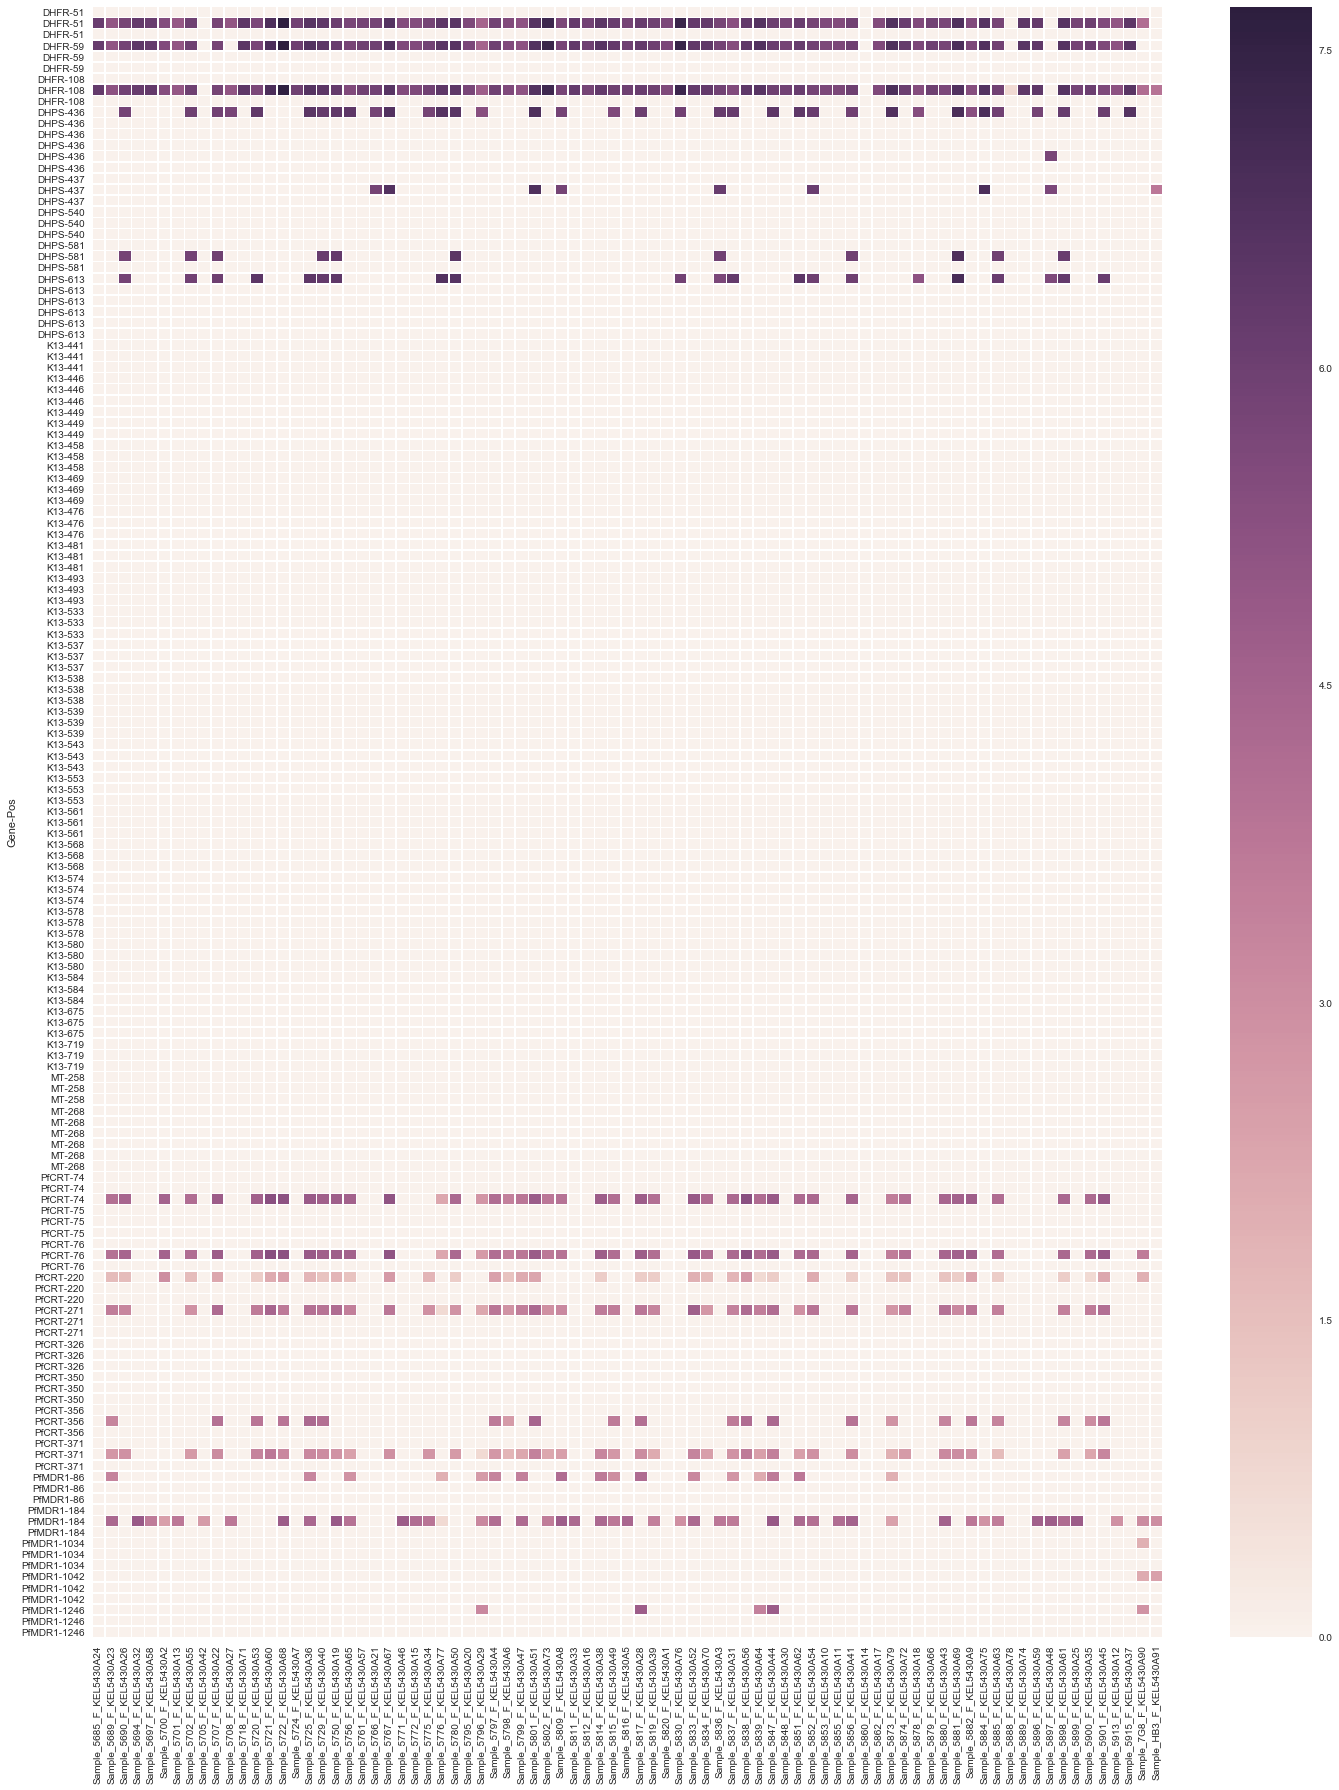

In [21]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("notebook")
plt.figure(figsize=(24,30))
heatmap = sns.heatmap(codons_of_int.loc[:,'Sample_5685_F_KEL5430A24':],linewidths=.5, square=False)
fig = heatmap.get_figure()
fig.savefig('heatmap.png')

In [22]:
heatmap